## The Geometry of Bézier splines

> **_Tip:_** Launch live version of this tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/morphomatics/morphomatics.github.io/HEAD?filepath=docs%2Ftutorials%2Ftutorial_bezierfol.ipynb)

It happens frequently that one is interested in the statistical analysis of curves. For example, in order to analyze longitudinal data (e.g., measurements from several subjects at different points in time in a medial study) statistically, **[hierarchical models](https://en.wikipedia.org/wiki/Multilevel_model)** (see also **[this paper](https://arxiv.org/abs/2111.15371)**) are widely used. By first approximating _subject-wise_ trends (the individual level) and _subsequently_ computing the statistics of these curves (the group level), they account for the fact that intra-subject measurements are highly correlated while inter-subject measurements are not.

In order to analyze Bézier splines thorugh a Riemannian manifold $M$ statistically, we need a Riemannian structure on the _space of Bézier curves_ that go through $M$. Such a structure is implemented in Morphomatics; see **[A Nonlinear Hierarchical Model for Longitudinal Data on Manifolds](https://arxiv.org/abs/2202.01180)** for the definitions. In this tutorial we show how it can be used to compute the mean of two Bézier splines in the 2-sphere $S^2$.

In [1]:
%env JAX_PLATFORM_NAME=cpu
import jax
import jax.numpy as jnp

from morphomatics.geom.BezierSpline import BezierSpline
from morphomatics.manifold.Bezierfold import Bezierfold
from morphomatics.manifold.Sphere import Sphere

env: JAX_PLATFORM_NAME=cpu


We start by initializing $S^2$ and the manifold of Bézier splines (''Bézierfold'') consisting of splines in $S^2$ with two quadratic segments; we also initialize the Riemannian structure on the Bézierfold.

In [2]:
M = Sphere()

B = Bezierfold(M, 2, 2)
B.initFunctionalBasedStructure()

The following lines create two splines as data.

In [3]:
North = jnp.array([0., 0., 1.])
South = jnp.array([0., 0., -1.])

p = jnp.array([1., 0., 0.])
o = jnp.array([1/jnp.sqrt(2), 1/jnp.sqrt(2), 0.])
om = M.connec.exp(o, jnp.array([0, 0, -.25]))
op = M.connec.exp(o, jnp.array([0, 0, .25]))
q = jnp.array([0, 1, 0.])

B1 = BezierSpline(M, [jnp.stack((p, om, o)), jnp.stack((o, op, q))])

z = M.connec.geopoint(o, North, .5)

p1 = jnp.array([1., 0., 0.])
o1 = M.connec.geopoint(p, z, .5)
om1 = M.connec.geopoint(p, z, .4)
op1 = M.connec.geopoint(p, z, .6)
q1 = z
B2 = BezierSpline(M, [jnp.stack((p1, om1, o1)), jnp.stack((o1, op1, q1))])

Now, we can compute the mean of the two splines and plot the results. Note that the solution is computed iteratively. Therefore, the parameters _n_, _delta_, and _nsteps_ can be used to balance speed and accuracy: The larger _n_ and _nsteps_ and the smaller _delta_, the more accurate (but the slower) the computation will be. Finally, we visualize the two splines and their mean.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
 1           +2.1628142893314362e-01    3.17587927e-02    
 2           +2.1622689068317413e-01    2.02613845e-02    
 3           +2.1621808409690857e-01    8.74805357e-03    
 4           +2.1621692180633545e-01    2.66757421e-03    
 5           +2.1621634066104889e-01    5.27441688e-03    
 6           +2.1621556580066681e-01    4.37484309e-03    
 7           +2.1621546149253845e-01    2.51648366e-03    
 8           +2.1621488034725189e-01    1.01092714e-03    
 9           +2.1621450781822205e-01    7.58398231e-03    
10           +2.1621440351009369e-01    5.44591248e-03    
11           +2.1621416509151459e-01    5.23709366e-03    
12           +2.1621309220790863e-01    1.31669361e-03    
13           +2.1621295809745789e-01    2.99815577e-03    
14           +2.1621283888816833e-01    1.08587462e-03    
15           +2.1621271967887878e-01    2.

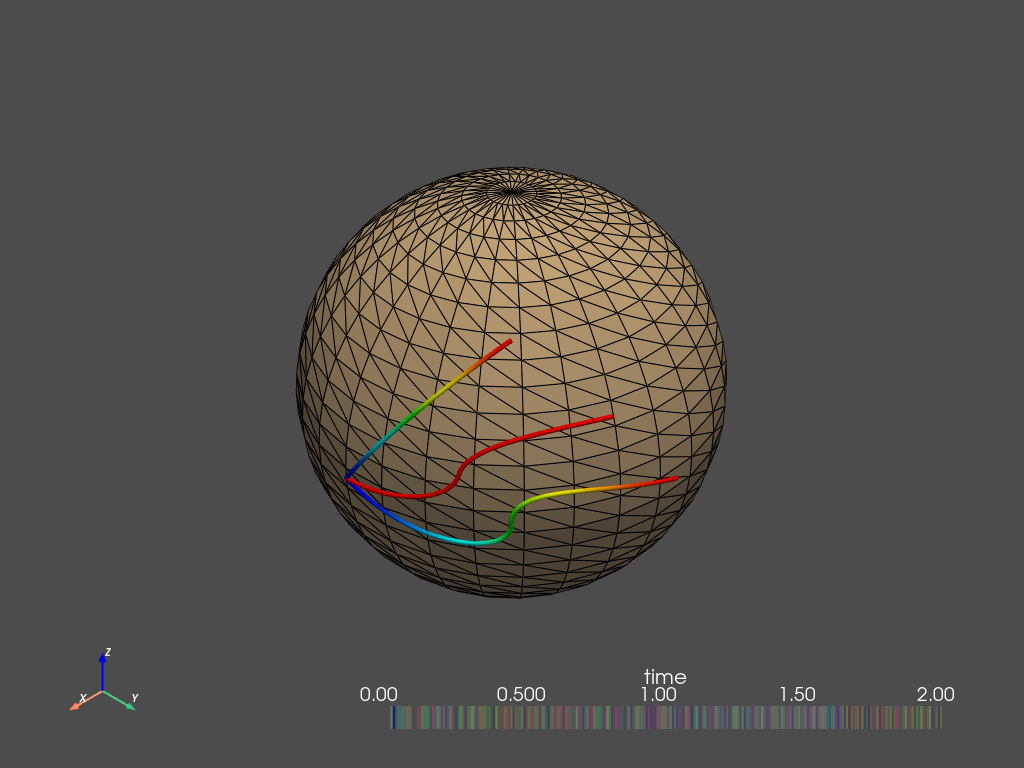

In [4]:
mean = B.metric.mean([B1, B2], n=3, delta=1e-5, nsteps=5)[0]

import numpy as np
import pyvista as pv

# Plotting methods
def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = np.asarray(points)
    cells = np.full((len(points)-1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points)-1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly


def tube_from_spline(B):
    """Get pyvista polydata object from spline B that can be plotted as tube
    """
    b = np.asarray([B.eval(t) for t in np.linspace(0, B.nsegments, 100)])
    line = lines_from_points(np.asarray(b))
    line["scalars"] = np.linspace(0, B.nsegments, 100)
    tube = line.tube(radius=0.01)
    return tube

# create a tubular surface interpolating points
def tube_mesh(pts, interval=(0,2)):
    n = len(pts)-1
    curve = pv.PolyData(pts)
    curve["time"] = np.linspace(*interval, curve.n_points)
    curve.lines = np.c_[np.full(n,2), np.arange(n), np.arange(n)+1]
    curve.tube(radius=0.01, inplace=True)
    return curve

pl = pv.Plotter(notebook=True)
sphere = pv.Sphere(1)
tube1 = tube_mesh(np.asarray(jax.vmap(B1.eval)(jnp.linspace(0., 2., num=100))))
tube2 = tube_mesh(np.asarray(jax.vmap(B2.eval)(jnp.linspace(0., 2., num=100))))

pl.add_mesh(tube_mesh(np.asarray(jax.vmap(mean.eval)(jnp.linspace(0., 2., num=100)))), color='red')
pl.add_mesh(tube1)
pl.add_mesh(tube2)

pl.add_mesh(sphere, color="tan", show_edges=True)

pl.show_axes()
pl.show(jupyter_backend='static')